<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_5_nn_lr_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Methods of classification and dimensionality reduction**


Paweł Lorek  
University of Wrocław

# LIST NR 5: Linear Regression (and extensions), classification and Neural Networks in PyTorch.


 <font face="Rage" size=2  > Updated: 08.04.2025 <font>

In [ ]:
# Paweł Lorek


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import time

from keras.datasets import mnist # <-- dataset from here, 28x28 images

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [ ]:
!pip install torchinfo
from torchinfo import summary as torch_summary

# Data Preparation
Load mnist dataset, classes = 0,1,...,9

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print("x_train.shape = ",x_train.shape)
print("x_test.shape = ",x_test.shape)

x_train.shape =  (60000, 28, 28)
x_test.shape =  (10000, 28, 28)


##Binary classification

we will start with binary classification, choose only digits 0 or 1

In [ ]:

x_train2, y_train2 = x_train[(y_train==0) | (y_train==1)], y_train[(y_train==0) | (y_train==1)]
x_test2, y_test2 = x_test[(y_test==0) | (y_test==1)], y_test[(y_test==0) | (y_test==1)]


# nr of samples, size  of images
n_samples_train, h, w =     x_train2.shape
n_samples_test, _, _ =      x_test2.shape
print("images of size: h= ", h,", w = ", w)
# reshape nr_samples * "vectorized image"

num_features = h*w

x_train2 = x_train2.reshape((-1, h*w))
x_test2 = x_test2.reshape((-1, h*w))

print("x_train2.shape = ", x_train2.shape)
print("x_test2.shape = ", x_test2.shape)

#normalize
x_train2 = x_train2 / 255
x_test2 = x_test2 / 255

images of size: h=  28 , w =  28
x_train2.shape =  (12665, 784)
x_test2.shape =  (2115, 784)


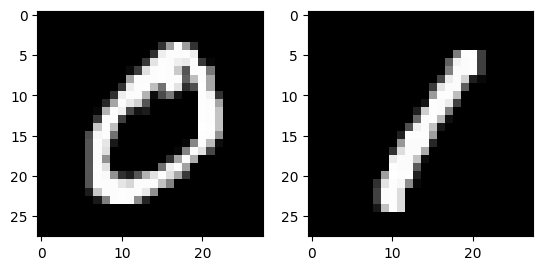

In [ ]:
f = plt.figure()
f.add_subplot(1,2, 1)
img=x_train2[0].reshape(h,w)
plt.imshow(img,cmap='gray')
img=x_train2[1].reshape(h,w)
f.add_subplot(1,2, 2)
plt.imshow(img,cmap='gray')
plt.show()

# Logistic classification recap
## binary classification


 Suppose we are to estimate if a person dies next year:
 $$Pr(death | \mathbf{x})$$
 where
 $$\mathbf{x}=(\textrm{age, yearly alcohol usage, cholesterol,...})$$

 We want some simple model:
 $$z=w_0+w_1x_1+\ldots+w_d x_d =\mathbf{x}^T\mathbf{w}\qquad (\mathbf{x}=(1,x_1,\ldots,x_d))$$
 Roughly speaking, the larger the above value,
 the larger the chances of death.

 We want to "transform" $z$ into probability.  One way, take
$$f(z)={1\over 1+e^{-z}}$$


Given data: $(\mathbf{x}_1,...,\mathbf{x}_n)$ ("train images"), $(y_1,\ldots,y_n)$, $y_i\in\{0,1\}$ ("y_train", "labels") we assume that y_i was a result of flipping a coin with succ. probl $f(z)$
$$Y_i\sim \textrm{Bernoulli}(f(z))$$
(**recall**:  we always use $z=w_0+w_1x_1+\ldots+x_dw_d$)

$$
Pr(Y_i=s)
 =\left\{
 \begin{array}{lll}
  f(z) & \textrm{if} & s=1\\
  1-f(z) & \textrm{if} & s=0\\  
 \end{array}\right.  \qquad \qquad = f(z)^s (1-f(z))^{1-s}
$$

And the probability that we observed $(y_1,\ldots,y_n)$ given current $(w_0,\ldots,w_d)$ (**here** $z_i=\mathbf{x}^T_i\mathbf{w}$)

$$L(\mathbf{w})=\prod_{i=1}^n Pr(Y_i=y_i|\mathbf{w}) =\prod_{i=1}^n f(z_i)^{y_i} (1-f(z_i))^{1-y_i}$$

We want to find $\textrm{argmax}_\mathbf{w} L(\mathbf{w})$, we have
$$\textrm{argmax}_\mathbf{w} L(\mathbf{w}) =\textrm{argmin}_\mathbf{w} BCE(\mathbf{w}), $$
  where
$$BCE(\mathbf{w}) = -{1\over n}\log L(\mathbf{w})= -{1\over n}\sum_{i=1}^n \left[y_i \log f(z_i)+(1-y_i)\log(1-f(z_i))\right]$$

This is **BINARY CROSS ENTROPY** LOSS FUNCTION!

# Simplest (?) NN

create 1 dense layer : in our case, m=h*w =28*28 = 784

![alt text](https://raw.githubusercontent.com/lorek/datasets/master/nn_1_denselayer.png)

where $$\sum = z= w_0 + x_1 w_1 + .... x_m w_m$$

Activation function, sigmoid (aka *logistic function*):
$$ f(z) = {1\over 1+ e^{-z}}$$

Note $f(z)\in (0,1)$ (probability)


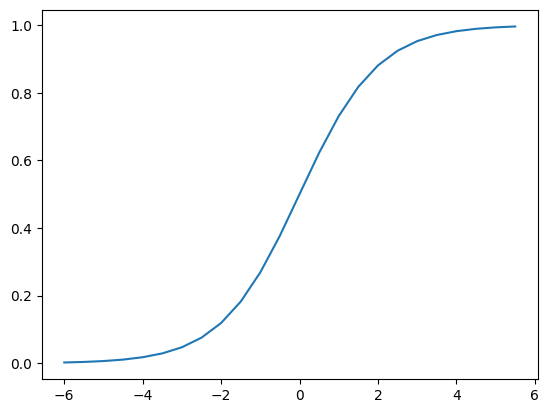

In [ ]:
xx=np.arange(-6,6, 0.5)
plt.plot(xx,1/(1+np.exp(-xx)))
plt.show()

Final classification
$$k(\mathbf{x})=k(x_1,\ldots,x_m) = \mathbf{1}(f(z)>0.5)$$


## Model creation
We create a logistic regression model using `nn.Sequential`.
The model maps input features directly to a probability by applying a linear transformation followed by the sigmoid activation.

In [ ]:
# see inital imports at the top

model_lr_torch = nn.Sequential(
    nn.Linear(num_features,1),
    nn.Sigmoid()).to(device)

*Remark: we could create a simple linear model `model_lr_torch = nn.Linear(num_features,1).to(device)` and then use `sigmoid` manually during training.*

In [ ]:
torch_summary(model_lr_torch)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            785
├─Sigmoid: 1-2                           --
Total params: 785
Trainable params: 785
Non-trainable params: 0

We need data as torch tensors

In [ ]:
x_train2_tensor = torch.tensor(x_train2, device=device, dtype=torch.float32 )
y_train2_tensor = torch.tensor(y_train2, device=device, dtype=torch.float32 ).unsqueeze(1) # shape (N,1)

x_test2_tensor = torch.tensor(x_test2, device=device, dtype=torch.float32 )
y_test2_tensor = torch.tensor(y_test2, device=device, dtype=torch.float32 ).unsqueeze(1) # shape (N,1)


# Create a TensorDataset and DataLoader
dataset = TensorDataset(x_train2_tensor, y_train2_tensor)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define the loss function and optimizer
BCE_loss = nn.BCELoss()
#optimizer = optim.SGD(model_lr_torch.parameters(), lr=0.1)
optimizer = optim.Adam(model_lr_torch.parameters(), lr=0.01)

num_epochs = 150
loss_history = []


start_time = datetime.now()


for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_X, batch_y in dataloader:
        # Move data to the device
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output_probs = model_lr_torch(batch_X)

        # Compute binary cross-entropy loss
        loss = BCE_loss(output_probs, batch_y)

        # Backward pass and update
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(dataloader)
    loss_history.append(average_loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}')

time_elapsed = datetime.now() - start_time
print('TRAINING TIME (hh:mm:ss.ms) {}'.format(time_elapsed))

Epoch [20/150], Loss: 0.000601
Epoch [40/150], Loss: 0.000158
Epoch [60/150], Loss: 0.000062
Epoch [80/150], Loss: 0.000022
Epoch [100/150], Loss: 0.000008
Epoch [120/150], Loss: 0.000003
Epoch [140/150], Loss: 0.000001
TRAINING TIME (hh:mm:ss.ms) 0:00:49.554410


Plot loss history:

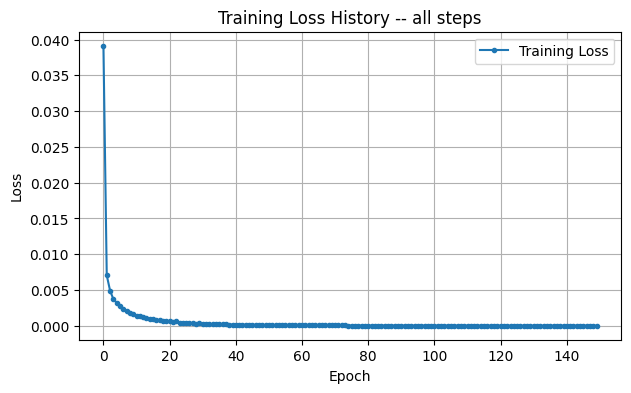

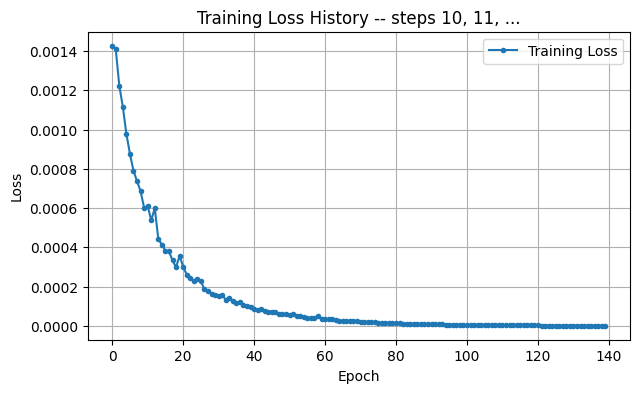

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(loss_history, marker='.', label='Training Loss')
plt.title('Training Loss History -- all steps')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.figure(figsize=(7, 4))
plt.plot(loss_history[10:], marker='.', label='Training Loss')
plt.title('Training Loss History -- steps 10, 11, ...')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Lets compute loss on all train data:

In [ ]:
output_probs = model_lr_torch(x_train2_tensor)


BCE_loss_train_built_in = BCE_loss(output_probs, y_train2_tensor)
print("BCE_loss_train_built_in = ",BCE_loss_train_built_in)

BCE_loss_train_built_in =  tensor(7.2585e-07, grad_fn=<BinaryCrossEntropyBackward0>)


Sanity check: should be the same as directly using formula (recall, $z_i$ is logit, and $f(z_i)={1\over 1+e^{-z_i}}$ is the resulting prob.)
$$BCE(\mathbf{w}) = -{1\over n}\log L(\mathbf{w})= -{1\over n}\sum_{i=1}^n \left[y_i \log f(z_i)+(1-y_i)\log(1-f(z_i))\right]$$

**TECHNICAL ISSUE:** log(0) is infinity. to avoid it we usually add some small epsilon to the values:

In [ ]:
eps = 1e-7
BCE_loss_train_manual = -torch.mean(y_train2_tensor*torch.log(output_probs+eps)+(1-y_train2_tensor)*torch.log(1-output_probs+eps))
print("BCE_loss_train_manual = ", BCE_loss_train_manual)

BCE_loss_train_manual =  tensor(6.0675e-07, grad_fn=<NegBackward0>)


Prediction:

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
#prediction
x_test2_pred_output_probs =  model_lr_torch(x_test2_tensor)

x_test2_pred_output_classes = (x_test2_pred_output_probs>0.5)

print("model_lr_torch (classification of 0 and 1 digits): accuracy  =  \t",accuracy_score(x_test2_pred_output_classes ,y_test2))

model_lr_torch (classification of 0 and 1 digits): accuracy  =  	 0.9995271867612293


Run logistic classifier from sklearn (to compare with our neural network implementation):

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#sklearn_lr = LogisticRegression(random_state=0, penalty="elasticnet", solver='saga', l1_ratio=0.5, max_iter=200).fit(x_train2,y_train2)
sklearn_lr = LogisticRegression(random_state=0).fit(x_train2,y_train2)

sklearn_y_pred=sklearn_lr.predict(x_test2)
print("Log. clf: accuracy  = \t",accuracy_score(sklearn_y_pred,y_test2), " correctly cl. cases=",np.sum(sklearn_y_pred==y_test2), " out of ", len(y_test2))
print("NN clf: accuracy  =  \t",accuracy_score(x_test2_pred_output_classes ,y_test2), " correctly cl. cases=",np.sum(x_test2_pred_output_classes.detach().numpy().reshape(-1)==y_test2), " out of ", len(y_test2))

Log. clf: accuracy  = 	 0.9995271867612293  correctly cl. cases= 2114  out of  2115
NN clf: accuracy  =  	 0.9995271867612293  correctly cl. cases= 2114  out of  2115


also compute BCE on test data:

In [ ]:
sklearn_pred_probs = sklearn_lr.predict_proba(x_test2)[:, 1]

# Compute BCE manually using the formula:
# BCE = -mean( y*log(prob) + (1-y)*log(1-prob) )
eps = 1e-7
BCE_sklearn = -np.mean(y_test2 * np.log(sklearn_pred_probs + eps) + (1 - y_test2) * np.log(1 - sklearn_pred_probs + eps))
print("Sklearn BCE on x_test2 =", BCE_sklearn)

# BCE -- model_lr_torch

output_probs_torch =  model_lr_torch(x_test2_tensor)

BCE_torch = -torch.mean(
    y_test2_tensor * torch.log(output_probs_torch + eps) +
    (1 - y_test2_tensor) * torch.log(1 - output_probs_torch + eps)
)
print("PyTorch BCE on x_test2 =", BCE_torch.item())

Sklearn BCE on x_test2 = 0.0015942733010772799
PyTorch BCE on x_test2 = 0.002224832074716687


Have a closer look at coefficients $w_0, \ldots, w_d$

In [ ]:
model_lr_torch[0].weight.shape

torch.Size([1, 784])

Sum(|lc_coef|) LC:  85.32542024022332
Sum(|nn_coef|) LC:  568.93646


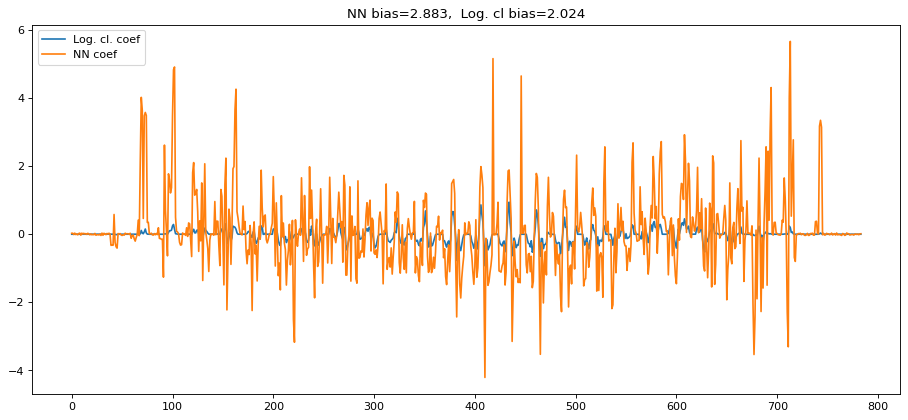

In [ ]:
# coef. and bias of logist. cl:
sklearn_lr_coef = sklearn_lr.coef_.reshape(-1)
sklearn_lr_bias = sklearn_lr.intercept_[0]

# coef and bias of model_tr_torch
nn_coef = model_lr_torch[0].weight.detach().cpu().numpy().reshape(-1)
nn_bias = model_lr_torch[0].bias.detach().cpu().numpy()[0]

#draw coefs
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.arange(h*w), sklearn_lr_coef, label="Log. cl. coef")
plt.plot(np.arange(h*w), nn_coef, label="NN coef")
plt.title("NN bias="+str(np.round(nn_bias,3)) + ",  Log. cl bias="+str(np.round(sklearn_lr_bias,3)));

print("Sum(|lc_coef|) LC: ", np.sum(np.abs(sklearn_lr_coef)))
print("Sum(|nn_coef|) LC: ", np.sum(np.abs(nn_coef)))

plt.legend()
plt.show()



Coefficients as images:

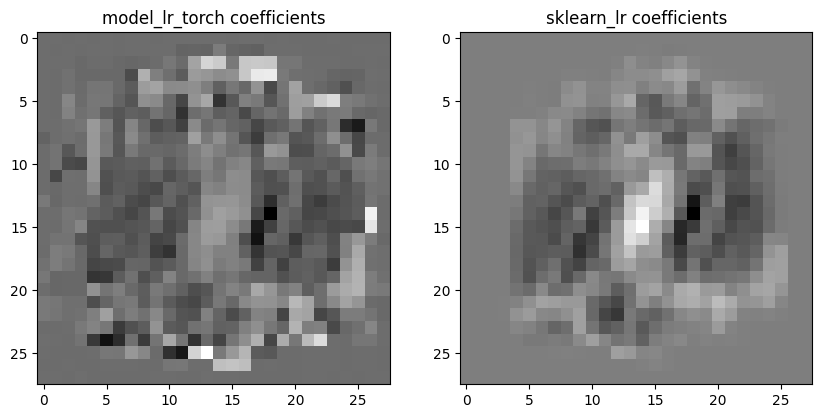

In [ ]:
f = plt.figure(figsize=(10, 10))

# First subplot with title "A"
ax1 = f.add_subplot(1, 2, 1)
ax1.imshow(nn_coef.reshape(h, w), cmap='gray')
ax1.set_title("model_lr_torch coefficients")

# Second subplot with title "B"
ax2 = f.add_subplot(1, 2, 2)
ax2.imshow(sklearn_lr_coef.reshape(h, w), cmap='gray')
ax2.set_title("sklearn_lr coefficients")

plt.show()

(100,)


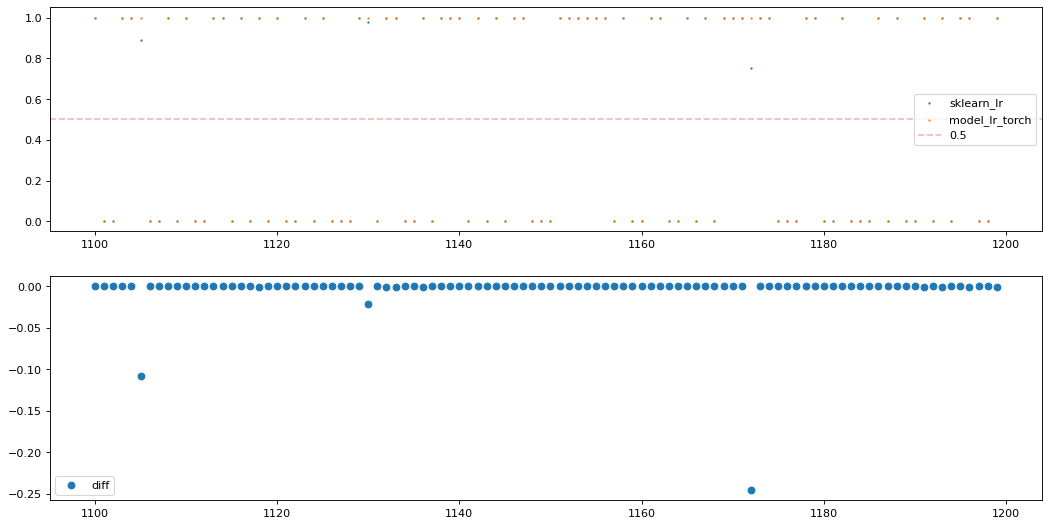

In [ ]:
output_probs_torch_numpy = output_probs_torch.detach().numpy()

fr=1100; to=1200
xx=np.arange(fr,to)
print(xx.shape)
f = plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
f.add_subplot(2,1, 1)
plt.scatter(xx,sklearn_pred_probs[fr:to], s=1,label='sklearn_lr');
plt.scatter(xx,output_probs_torch_numpy[fr:to], s=1,label='model_lr_torch');
plt.axhline(y=0.5, color='r', linestyle='--', label="0.5", alpha=0.3)
#

plt.legend()

f.add_subplot(2,1, 2)
plt.scatter(xx,sklearn_pred_probs[fr:to]-output_probs_torch_numpy[fr:to].reshape(-1), label='diff');
plt.legend()
plt.show()




# Q5.1 (10 pts)

* Above we implemented logistic regression as the following  network with 1  neuron:
```python
model_lr_torch = nn.Sequential(
    nn.Linear(num_features,1),
    nn.Sigmoid()).to(device)
```
* **Task** Reimplement  he model using:
```python
model_lr_torch_v2 = nn.Sequential(
    nn.Linear(num_features,1)    
```
* Since the output is now a raw real number (logit), adjust the loss function accordingly. Compare the results with those from `model_lr_torch`
* *Hint*: When computing $\log(s)$ in practice, to avoid numerical issues (such as $\log(0)$), add a small constant and compute  $\log(s+\textrm{eps})$ instead. A recommended value is: `eps=1e-7`



# Multiclass, still 1 layer

Now we will classify digits 0,1,2,3

In [ ]:
x_trainM, y_trainM = x_train , y_train
x_testM, y_testM = x_test , y_test



x_trainM, y_trainM = x_train[y_train<=3], y_train[y_train<=3]
x_testM, y_testM = x_test[y_test<=3], y_test[y_test<=3]


# nr of samples, size  of images
n_samples_trainM, h, w =     x_trainM.shape
n_samples_testM, _, _ =      x_testM.shape
print("images of size: h= ", h,", w = ", w)

num_features = h*w

x_trainM = x_trainM.reshape((-1, h*w))
x_testM = x_testM.reshape((-1, h*w))

print("x_trainM.shape = ", x_trainM.shape)
print("x_testM.shape = ", x_testM.shape)

#normalize
x_trainM = x_trainM / 255
x_testM = x_testM / 255

images of size: h=  28 , w =  28
x_trainM.shape =  (24754, 784)
x_testM.shape =  (4157, 784)


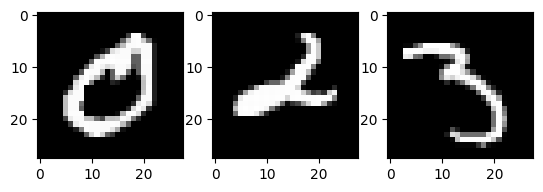

In [ ]:
f = plt.figure()
f.add_subplot(1,3, 1)
img=x_trainM[10].reshape(h,w)
plt.imshow(img,cmap='gray')
img=x_trainM[331].reshape(h,w)
f.add_subplot(1,3, 2)
plt.imshow(img,cmap='gray')
img=x_trainM[39].reshape(h,w)
f.add_subplot(1,3,3)
plt.imshow(img,cmap='gray')
plt.show()

# This time -- let us have a look how is Logist. Class. applied in case of >2 classes.

## Solution 1: one-versus-rest (image: Andrew Ng)
<div>
<img src="https://raw.githubusercontent.com/lorek/datasets/master/LogClass_oneVsRest.png" width="700"/>
</div>
Then final probability of $x$ belonging to class $j$
$$\textrm{Prob}(\textrm{class = } j| x) = {h_{\theta}^{(j)}(x)\over h_{\theta}^{(1)}(x)+h_{\theta}^{(2)}(x)+h_{\theta}^{(3)}(x)} $$
and finall classification
$$\textrm{Class}(x)={\textrm{argmax}_j} \textrm{Prob}(\textrm{class = } j| x)$$


## Solution 2: "Multinomial"  

Recall, in binary case we had:
$$P(Y=1 | \mathbf{x}) = f(\mathbf{w}^T\mathbf{x})=f(z)={1\over 1+e^{-z}}={e^z\over 1+e^{z}} \propto e^z$$


Thus, natural extension: when $Y\in\{1,2,\ldots,C\}$, then we create weights for each class:
$$\mathbf{w}_i=(w_{i0}, w_{i1},\ldots, w_{id})^T$$

And assume that the model is
$$P(Y=k|\mathbf{x})\propto e^{\mathbf{w}^T_k\mathbf{x}}$$

Normalizing we have
$$P(Y=k|\mathbf{x})= {e^{\mathbf{w}^T_k\mathbf{x}}\over \sum_{j=1}^C e^{\mathbf{w}^T_j\mathbf{x}}}$$


**SOFTMAX:** transforming $(z_1,..., z_C), z_i\in\mathbb{R}$ into probabilites:
$$\textrm{softmax}(z_i)={e^{z_i}\over \sum_{j=1}^C e^{z_j}}$$

How to compute Likelihood then?
$$L(\mathbf{W})=\prod_{i=1}^n P(Y=y_i|\mathbf{x}_i)=\prod_{i=1}^n\prod_{k=1}^C \left( {e^{\mathbf{w}_k^T\mathbf{x}_i}\over \sum_{i=1}^C e^{\mathbf{w}_k^T\mathbf{x}_i}}\right)^{\mathbf{1}(y_i=k)}$$

take log
$$\log L(\mathbf{W}) = \sum_{i=1}^n\sum_{k=1}^C \mathbf{1}(y_i=k)\log\left( {e^{\mathbf{w}_k^T\mathbf{x}_i}\over \sum_{i=1}^C e^{\mathbf{w}_k^T\mathbf{x}_i}}\right)$$

and we aim to find $\textrm{argmax}_\mathbf{W} \log(\mathbf{W})$ what is equiv. to finding $\textrm{argmin}_\mathbf{W} CCE(\mathbf{W})$, where
$$\textrm{CCE}(\mathbf{W})  = -\log L(\mathbf{W})$$

 **CCE = Categorical Cross Entropy**

# Binary vs Multiclass:
![alt text](https://raw.githubusercontent.com/lorek/datasets/master/nn_1_denselayerSoftmax.png)

## Logist. class. in sklearn
### MULTINOMIAL

In [ ]:
start_time = time.time()
sklearn_lr_M_multin = LogisticRegression(random_state=0, max_iter=200,   multi_class='multinomial').fit(x_trainM,y_trainM)

print("\t\t took %s seconds " % round((time.time() - start_time),5))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


		 took 11.89141 seconds 


### One-vs-all (aka one-vs-rest)


In [ ]:
start_time = time.time()
sklearn_lr_M_ovr = LogisticRegression(random_state=0, max_iter=200,   multi_class='ovr').fit(x_trainM,y_trainM)

print("\t\t took %s seconds " % round((time.time() - start_time),5))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


		 took 8.85654 seconds 


In [ ]:
sklearn_lr_M_multin_pred=sklearn_lr_M_multin.predict(x_testM)

sklearn_lr_M_ovr_pred =sklearn_lr_M_ovr.predict(x_testM)

print("sklearn_lr_M_multin accuracy  = \t",accuracy_score(sklearn_lr_M_multin_pred,y_testM), " correctly cl. cases=",np.sum(sklearn_lr_M_multin_pred==y_testM))
print("sklearn_lr_M_ovr: accuracy  = \t\t",accuracy_score(sklearn_lr_M_ovr_pred,y_testM), " correctly cl. cases=",np.sum(sklearn_lr_M_ovr_pred==y_testM))


sklearn_lr_M_multin accuracy  = 	 0.9781092133750301  correctly cl. cases= 4066
sklearn_lr_M_ovr: accuracy  = 		 0.9754630743324513  correctly cl. cases= 4055


## Neural Network, Torch implementation, 1 layer, multiclass


### Data preparation

In [ ]:
#Convert data to PyTorch tensors:

x_trainM_tensor = torch.tensor(x_trainM, dtype=torch.float32)
x_testM_tensor  = torch.tensor(x_testM, dtype=torch.float32)

# Convert labels to tensor (as integers)
y_trainM_tensor = torch.tensor(y_trainM, dtype=torch.long)
y_testM_tensor  = torch.tensor(y_testM, dtype=torch.long)


In [ ]:
#classes of first three data points (digits)
y_testM_tensor[0]

tensor(2)

However, we need one-hot encoding: we have 4 classes {0,1,2,3}, then e.g., class 2 should be represented as vector [0,0,1,0] and so on.


In [ ]:
import torch.nn.functional as F

# Create one-hot encodings
num_classes = 4
y_trainM_one_hot = F.one_hot(y_trainM_tensor, num_classes=num_classes).float()
y_testM_one_hot  = F.one_hot(y_testM_tensor, num_classes=num_classes).float()

print("y_testM_one_hot[0, :] =", y_testM_one_hot[0, :])
print("y_testM_one_hot.shape =", y_testM_one_hot.shape)


y_testM_one_hot[0, :] = tensor([0., 0., 1., 0.])
y_testM_one_hot.shape = torch.Size([4157, 4])


In [ ]:
# Create DataLoader for training data
batch_size = 16
train_dataset = TensorDataset(x_trainM_tensor, y_trainM_one_hot)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Thus, using **activation='softmax'** we have a logistic regression!



In [ ]:
print("num_classes = ",num_classes, ", num_features = ", num_features)

num_classes =  4 , num_features =  784


In [ ]:
# Build the model: Linear layer with softmax activation (to output probabilities)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_lr4_torch = nn.Sequential(
    nn.Linear(num_features, num_classes),
    nn.Softmax(dim=1)
).to(device)


In [ ]:
torch_summary(model_lr4_torch)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            3,140
├─Softmax: 1-2                           --
Total params: 3,140
Trainable params: 3,140
Non-trainable params: 0

The situation is like this (image is with 3 classes, we consider 4 classes)

<img src="https://raw.githubusercontent.com/lorek/datasets/refs/heads/master/nn_1l_softmax.png" alt="alt text" width="400">

Thus:
* **Input Layer** accepts a vector with 784 features (in our case, a flattened $28\times 28$ images)
* **Linear Layer** has 4 output neurons (one for each class). Each neuron computes a weighted sum of the 784 inputs plus bias. Suppose we represent all the parameters in a matrix $W$ of size `num_classes * (num_features+1)` (the extra column accounts for the biases, which can be stored as $W_{j,0}$ for neuron $j$). Then the output of each neuron $j=1,2,3,4$ is  given by
$$z_j = W_{j,0} + \sum_{i=1}^{784} W_{j,i} x_i$$
* **Softmax Layer**. The softmax is applied to 4 output values from the linear layer. It converts raw outputs (logits) into probabilities. In our example, it returns a vector
$$\left[ {e^{z_1}\over \sum_{j=1}^4 e^{z_j}}, {e^{z_2}\over \sum_{j=1}^4 e^{z_j}}, {e^{z_3}\over \sum_{j=1}^4 e^{z_j}}, {e^{z_4}\over \sum_{j=1}^4 e^{z_j}}\right]$$

Recall Categorical Cross Entropy:

$$\textrm{CCE}(\mathbf{W})  = - \log L(\mathbf{W}) = - \sum_{i=1}^n\sum_{k=1}^C \mathbf{1}(y_i=k)\log\left( {e^{\mathbf{w}_k^T\mathbf{x}_i}\over \sum_{i=1}^C e^{\mathbf{w}_k^T\mathbf{x}_i}}\right)$$

$$\textrm{CCE}(\mathbf{W})  = -\log L(\mathbf{W})$$

 **CCE = Categorical Cross Entropy**

In [ ]:
def categorical_crossentropy(predictions, targets, eps=1e-7):
    # predictions are probabilities, targets are one-hot encoded
    return -torch.mean(torch.sum(targets * torch.log(predictions + eps), dim=1))

In [ ]:
# Training

# Setup optimizer
optimizer = optim.Adam(model_lr4_torch.parameters(), lr=0.01)


num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model_lr4_torch(batch_x)
        loss = categorical_crossentropy(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    average_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

print("\t\t took %s seconds " % round((time.time() - start_time), 5))

Epoch [1/10], Loss: 0.1333
Epoch [2/10], Loss: 0.1203
Epoch [3/10], Loss: 0.1187
Epoch [4/10], Loss: 0.1143
Epoch [5/10], Loss: 0.1152
Epoch [6/10], Loss: 0.1124
Epoch [7/10], Loss: 0.1057
Epoch [8/10], Loss: 0.1037
Epoch [9/10], Loss: 0.1107
Epoch [10/10], Loss: 0.1060
		 took 18.81222 seconds 


In [ ]:
batch_x[0].shape, batch_y[0].shape

(torch.Size([784]), torch.Size([4]))

In [ ]:
output_probs = model_lr4_torch(x_testM_tensor.to(device))

# Get the predicted class by taking the argmax along the class dimension
model_l4_predicted_classes = output_probs.argmax(dim=1)


print("sklearn_lr_M_multin accuracy  = \t",accuracy_score(sklearn_lr_M_multin_pred,y_testM), " correctly cl. cases=",np.sum(sklearn_lr_M_multin_pred==y_testM))
print("sklearn_lr_M_ovr: accuracy  = \t\t",accuracy_score(sklearn_lr_M_ovr_pred,y_testM), " correctly cl. cases=",np.sum(sklearn_lr_M_ovr_pred==y_testM))
print("model_lr4: accuracy  = \t\t\t",accuracy_score(model_l4_predicted_classes,y_testM), " correctly cl. cases=",np.sum(model_l4_predicted_classes.detach().numpy()==y_testM))



sklearn_lr_M_multin accuracy  = 	 0.9781092133750301  correctly cl. cases= 4066
sklearn_lr_M_ovr: accuracy  = 		 0.9754630743324513  correctly cl. cases= 4055
model_lr4: accuracy  = 			 0.9764253067115708  correctly cl. cases= 4059


## Deeper (2-layer) network:

In [ ]:
model_4digits_torch_2_layers = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),
    nn.Softmax(dim=1)  # Output probabilities
).to(device)

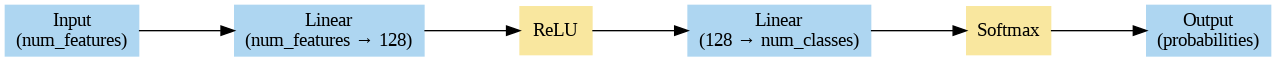

In [ ]:
optimizer = optim.Adam(model_4digits_torch_2_layers.parameters(), lr=0.001)

n_epochs = 10
start_time = time.time()


for epoch in range(n_epochs):
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        # Move data to the device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: compute model outputs (probabilities)
        outputs = model_4digits_torch_2_layers(x_batch)

        # Compute the custom categorical cross-entropy loss
        loss = categorical_crossentropy(outputs, y_batch)

        # Backward pass and update
        loss.backward()
        optimizer.step()

        # Accumulate loss (scaled by the number of samples in the batch)
        running_loss += loss.item() * x_batch.size(0)

    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")

print("Training completed in {:.2f} seconds".format(time.time() - start_time))

Epoch 1/10, Loss: 1.681829
Epoch 2/10, Loss: 0.675318
Epoch 3/10, Loss: 0.402613
Epoch 4/10, Loss: 0.271039
Epoch 5/10, Loss: 0.204537
Epoch 6/10, Loss: 0.134354
Epoch 7/10, Loss: 0.087279
Epoch 8/10, Loss: 0.088327
Epoch 9/10, Loss: 0.078552
Epoch 10/10, Loss: 0.074310
Training completed in 55.12 seconds


In [ ]:
output_probs_2l = model_4digits_torch_2_layers(x_testM_tensor.to(device))
# Get the predicted class by taking the argmax along the class dimension
model_l4_predicted_classes_2l = output_probs_2l.argmax(dim=1)
print("model_4digits_torch_2_layers  = \t\t\t",accuracy_score(model_l4_predicted_classes_2l,y_testM), " correctly cl. cases=",np.sum(model_l4_predicted_classes_2l.detach().numpy()==y_testM))


model_4digits_torch_2_layers  = 			 0.9942266057252827  correctly cl. cases= 4133


# Q5.2 (10 pts)
**Q5.2 STARTS**

* Implement a neural network with the same architecture as `model_4digits_torch_2_layers, but without using `torch.nn` modules

* It is convenient first to augment data -- currently we have 784 features, we will add one extra column (first one) with fixed value of 1:


In [ ]:
# Prepend a column of ones to x_trainM_tensor
ones_column = torch.ones(x_trainM_tensor.size(0), 1, device=x_trainM_tensor.device)
x_trainM_tensor_augmented = torch.cat((ones_column, x_trainM_tensor), dim=1)
print("Augmented x_trainM_tensor shape:", x_trainM_tensor_augmented.shape)  # Expected: [num_samples, 785]

# Create TensorDataset and DataLoader using the augmented data
batch_size = 16
train_dataset_augmented = TensorDataset(x_trainM_tensor_augmented, y_trainM_one_hot)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)

Augmented x_trainM_tensor shape: torch.Size([24754, 785])


*  The original input vector has 784 features, denote augmented input as $\mathbf{x}_{\text{aug}}$:
* $$
\mathbf{x} =
\begin{bmatrix}
x_1 \\ x_2 \\ \vdots \\ x_{784}
\end{bmatrix} \in \mathbb{R}^{784},
\qquad
\mathbf{x}_{\text{aug}} =
\begin{bmatrix}
1 \\ x_1 \\ x_2 \\ \vdots \\ x_{784}
\end{bmatrix} \in \mathbb{R}^{785}.
$$
* Define the first weight matrix
$
\mathbf{W}_1 \in \mathbb{R}^{785 \times 128}.
$
*Compute the hidden representation using the ReLU activation:
$$
\mathbf{H} = \operatorname{ReLU}\left( \mathbf{x}_{\text{aug}}^\top \mathbf{W}_1 \right).
$$
* **Hint:** Use `torch.relu` to perform the ReLU operation element-wise.
* Next, to incorporate the bias for the hidden-to-output layer, augment the hidden representation by prepending 1. Denote this augmented hidden representation by
$
\mathbf{H}_{\text{aug}} \in \mathbb{R}^{129}\quad (\text{since } 128+1 = 129).
$
* Define the second weight matrix
$$
\mathbf{W}_2 \in \mathbb{R}^{129 \times 4}.
$$
* Compute the output logits as follows:
$$
\mathbf{y}_{\text{logits}} = \mathbf{H}_{\text{aug}}^\top \mathbf{W}_2.
$$
Finally, obtain the class probabilities by applying the softmax function:
$$
\mathbf{y}_{\text{probs}} = \operatorname{softmax}\left(\mathbf{y}_{\text{logits}}\right).
$$
* Your **task** is to implement this network using only `PyTorch` tensor operations (i.e., matrix multiplications) without any `torch.nn` layers. Augment the input data as described, define and initialize the matrices ($\textbf{W}$ for weights and $\textbf{H}$ for the hidden representation) properly, compute the forward pass using `torch.relu` for the activation, and use an optimizer (e.g., `torch.optim.Adam` to update the weight matrices during training on a dataset with one-hot encoded targets.
* Below a template for solution is written, "just" write function `forward()`



* Below is the example, where `batch_x` is of shape (16,10) (i.e., 10 points, each 10dimensional, assume it is already augmented). We will create random $\textbf{W}$ of size $10\times 6$ (which mimics 6 neurons), compute hidden representation as
$$\mathbf{H} = \mathbf{x}_{\text{batch}} \, \mathbf{W} \in \mathbb{R}^{16 \times 6}.$$
To incorporate a bias term for subsequent layers, we augment \(\mathbf{H}\) by prepending a column of ones. Formally, let:
$$
\mathbf{1} \in \mathbb{R}^{16 \times 1} \quad \text{(a column vector of ones)},
$$
then the augmented hidden representation is given by:
$$
\mathbf{H}_{\text{aug}} = \begin{bmatrix} \mathbf{1} & \mathbf{H} \end{bmatrix} \in \mathbb{R}^{16 \times 7}.
$$

In [ ]:
# Create a random weight matrix W of shape (10, 6), which mimics 6 neurons
W = torch.randn(10, 6)

# Create a random batch of inputs x_batch of shape (16, 10) (one data x = row)
x_batch = torch.randn(16, 10)

# Compute the hidden representation H = x_batch @ W (for one x it is: x^T *W), resulting in shape (16, 6)
H = torch.matmul(x_batch, W)

# Apply the ReLU activation element-wise
H_relu = torch.relu(H)

# Augment H_relu by adding a column of ones at the beginning (for bias)
ones = torch.ones(H_relu.shape[0], 1)
H_aug = torch.cat((ones, H_relu), dim=1)  # new shape: (16, 7)

print("x_batch shape:", x_batch.shape)   # Expected: (16, 10)
print("W shape:", W.shape)               # Expected: (10, 6)
print("H shape:", H.shape)               # Expected: (16, 6)
print("H_relu shape:", H_relu.shape)     # Expected: (16, 6)
print("H_aug shape:", H_aug.shape)       # Expected: (16, 7)

x_batch shape: torch.Size([16, 10])
W shape: torch.Size([10, 6])
H shape: torch.Size([16, 6])
H_relu shape: torch.Size([16, 6])
H_aug shape: torch.Size([16, 7])


* **Template of solution**

In [ ]:
# Initialize weight matrices
W1 = torch.randn(785, 128, device=device, requires_grad=True)
W2 = torch.randn(129, 4, device=device, requires_grad=True)

optimizer = optim.Adam([W1, W2], lr=0.001)



In [ ]:
def forward(batch_x):
  print("TO DO")

In [ ]:
n_epochs = 20

for epoch in range(n_epochs):
    running_loss = 0.0
    for batch_x, batch_y in train_loader_augmented:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        preds = forward(batch_x)
        loss = categorical_crossentropy(preds, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")

* Predictions/accuracy:

In [ ]:
# Augment the test data: prepend a column of ones
x_testM_tensor_aug = torch.cat((torch.ones(x_testM_tensor.size(0), 1, device=x_testM_tensor.device),
                                x_testM_tensor), dim=1)  # New shape: (N, 785)

# Compute predictions using the forward function defined previously.
preds_test = forward(x_testM_tensor_aug)

# Get predicted classes by taking the index with the highest probability for each sample.
predicted_classes = preds_test.argmax(dim=1)


print("W1, W2, accuracy  = \t",accuracy_score(predicted_classes,y_testM), " correctly cl. cases=",np.sum(predicted_classes.detach().numpy()==y_testM))


W1, W2, accuracy  = 	 0.9915804666827038  correctly cl. cases= 4122


**Q5.2 ENDS**

## Deeper (3-layer) network:

In [ ]:
model_4digits_torch_deeper = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, num_classes),
    nn.Softmax(dim=1)
).to(device)

In [ ]:
torch_summary(model_4digits_torch_deeper)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            100,480
├─ReLU: 1-2                              --
├─Linear: 1-3                            8,256
├─ReLU: 1-4                              --
├─Linear: 1-5                            2,080
├─ReLU: 1-6                              --
├─Linear: 1-7                            132
├─Softmax: 1-8                           --
Total params: 110,948
Trainable params: 110,948
Non-trainable params: 0

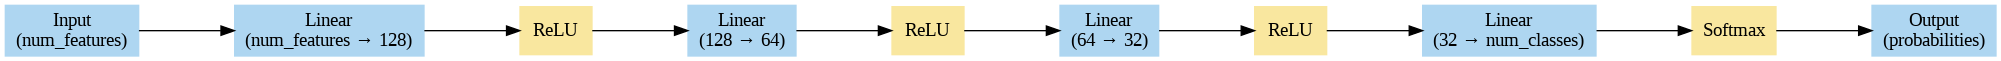

In [ ]:
# Setup optimizer (using Adam)
optimizer = optim.Adam(model_4digits_torch_deeper.parameters(), lr=0.01)

# Training loop
num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model_4digits_torch_deeper(batch_x)
        loss = categorical_crossentropy(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    average_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

print("\t\t took %s seconds " % round((time.time() - start_time), 5))

Epoch [1/10], Loss: 0.1233
Epoch [2/10], Loss: 0.0764
Epoch [3/10], Loss: 0.0672
Epoch [4/10], Loss: 0.0592
Epoch [5/10], Loss: 0.0480
Epoch [6/10], Loss: 0.0529
Epoch [7/10], Loss: 0.0619
Epoch [8/10], Loss: 0.0728
Epoch [9/10], Loss: 0.0479
Epoch [10/10], Loss: 0.0371
		 took 83.06585 seconds 


In [ ]:
output_probs_deeper = model_4digits_torch_deeper(x_testM_tensor.to(device))

# Get the predicted class by taking the argmax along the class dimension
model_4digits_deeper_predicted_classes = output_probs_deeper.argmax(dim=1)


print("sklearn_lr_M_multin accuracy  = \t",accuracy_score(sklearn_lr_M_multin_pred,y_testM), " correctly cl. cases=",np.sum(sklearn_lr_M_multin_pred==y_testM), " out of ",len(y_testM))
print("sklearn_lr_M_ovr: accuracy  = \t\t",accuracy_score(sklearn_lr_M_ovr_pred,y_testM), " correctly cl. cases=",np.sum(sklearn_lr_M_ovr_pred==y_testM), " out of ",len(y_testM))
print("model_lr4: accuracy  = \t\t\t",accuracy_score(model_l4_predicted_classes,y_testM), " correctly cl. cases=",np.sum(model_l4_predicted_classes.detach().numpy()==y_testM), " out of ",len(y_testM))
print("model_lr4_deeper: accuracy  = \t\t",accuracy_score(model_4digits_deeper_predicted_classes,y_testM), " correctly cl. cases=",np.sum(model_4digits_deeper_predicted_classes.detach().numpy()==y_testM), " out of ",len(y_testM))



sklearn_lr_M_multin accuracy  = 	 0.9781092133750301  correctly cl. cases= 4066  out of  4157
sklearn_lr_M_ovr: accuracy  = 		 0.9754630743324513  correctly cl. cases= 4055  out of  4157
model_lr4: accuracy  = 			 0.9764253067115708  correctly cl. cases= 4059  out of  4157
model_lr4_deeper: accuracy  = 		 0.9843637238393071  correctly cl. cases= 4092  out of  4157


## Three-layer network (torch) and sklearn log. regr. for all 10 classes

In [ ]:
# Flatten images and scale pixel values to [0,1]
x_train10 = x_train.reshape(-1, 28*28).astype(np.float32) / 255.0
x_test10  = x_test.reshape(-1, 28*28).astype(np.float32) / 255.0

print("x_train10 shape:", x_train10.shape)
print("x_test10 shape:", x_test10.shape)

x_train10 shape: (60000, 784)
x_test10 shape: (10000, 784)


## sklearn LR:

**NOTE: BELOW CODE (Logistic Regression) from sklearn takes ~ 1.5 min**


In [ ]:
# may take ~ 100 sec.


sklear_lr10 = LogisticRegression(max_iter=1000, random_state=0)
start_time = time.time()
print("Training sklearn LR model....")
sklear_lr10.fit(x_train10, y_train)
print("\t\t took %s seconds " % round((time.time() - start_time), 5))

# Predict and evaluate on test data
sklearn_preds = sklear_lr10.predict(x_test10)
acc_sklearn = accuracy_score(y_test, sklearn_preds)

print("sklear_lr10: accuracy  = \t\t",acc_sklearn)



Training sklearn LR model....
		 took 100.15691 seconds 
sklear_lr10: accuracy  = 		 0.9255


Torch impl

In [ ]:
# Convert data to PyTorch tensors
x_train10_tensor = torch.tensor(x_train10, dtype=torch.float32)
x_test10_tensor  = torch.tensor(x_test10, dtype=torch.float32)

# For one-hot encoding, convert labels (integers) to one-hot vectors
num_classes = 10
y_train10_tensor = torch.tensor(y_train, dtype=torch.long)
y_test10_tensor  = torch.tensor(y_test, dtype=torch.long)

y_train10_one_hot = F.one_hot(y_train10_tensor, num_classes=num_classes).float()
y_test10_one_hot  = F.one_hot(y_test10_tensor, num_classes=num_classes).float()

# Create a TensorDataset and DataLoader for training
batch_size = 128
train_dataset = TensorDataset(x_train10_tensor, y_train10_one_hot)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define the deeper model with 3 hidden layers, ending with Softmax
model_10digits_torch_deeper = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, num_classes),
    nn.Softmax(dim=1)
).to(device)

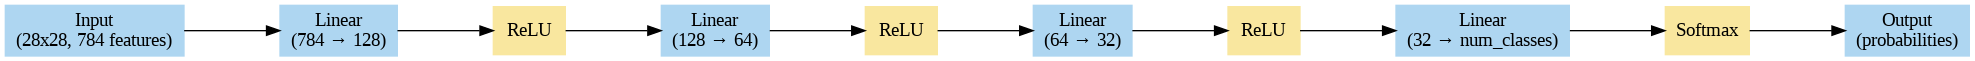

In [ ]:
# Setup optimizer
optimizer = optim.Adam(model_10digits_torch_deeper.parameters(), lr=0.001)

num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    model_10digits_torch_deeper.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model_10digits_torch_deeper(batch_x)
        loss = categorical_crossentropy(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("PyTorch training took {:.2f} seconds".format(time.time() - start_time))

Epoch [1/10], Loss: 0.4970
Epoch [2/10], Loss: 0.1898
Epoch [3/10], Loss: 0.1323
Epoch [4/10], Loss: 0.1003
Epoch [5/10], Loss: 0.0794
Epoch [6/10], Loss: 0.0661
Epoch [7/10], Loss: 0.0560
Epoch [8/10], Loss: 0.0450
Epoch [9/10], Loss: 0.0392
Epoch [10/10], Loss: 0.0341
PyTorch training took 40.26 seconds


In [ ]:
model_10digits_torch_deeper.eval()
with torch.no_grad():
    test_outputs = model_10digits_torch_deeper(x_test10_tensor.to(device))
    # Get predicted classes by taking argmax
    torch_preds = test_outputs.argmax(dim=1).cpu().numpy()

acc_torch = accuracy_score(y_test, torch_preds)
print(y_test)

[7 2 1 ... 4 5 6]


In [ ]:

print("model_10digits_deeper: accuracy  = \t\t",accuracy_score(torch_preds ,y_test), " correctly cl. cases=",np.sum(torch_preds==y_test), " out of ",len(y_test))


model_10digits_deeper: accuracy  = 		 0.9766  correctly cl. cases= 9766  out of  10000


In [ ]:
print("sklear_lr10: accuracy  = \t\t",acc_sklearn)

sklear_lr10: accuracy  = 		 0.9255


# Q5.3
**Q5.3 STARTS**
* In this task you will classify `Wine dataset`, which is a 3-class dataset (wines from 3 different cultivars) comprising 178 samples with 13 chemical features each.
* First, let us read in dataset, split it into train and test set, and transform it to torch:

In [ ]:

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Wine dataset: 178 samples, 13 features, 3 classes.
wine = load_wine()
X = wine.data
y = wine.target

# Split into train/test (80%/20%) with stratification.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Convert data to torch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# One-hot encode target labels (for 3 classes).
y_train_tensor = F.one_hot(y_train_tensor, num_classes=3).float()
y_test_tensor = F.one_hot(y_test_tensor, num_classes=3).float()

# Create DataLoader for training set.
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

* **TASK** Create a simple three-layer network with the following architecture:

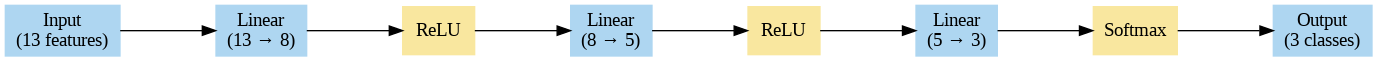

* Train the model with `Adam` optimizer with `lr=0.01` for `n_epochs=500`.
* Compute final accuracy. Check if decreasing batch size (e.g., `batch_size=16`) improves the results.

**Q5.3 ENDS**